In [1]:
# import libraries
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

In [2]:
# load the dataset and apply column names
col_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
         'race','gender','capital-gain','capital-loss','hours-per-week','native-country','income']
categorical = ['workclass','education','marital-status','occupation','relationship','gender','native-country','race','income']
to_keep = ['age','workclass','education','marital-status','occupation','race','gender','native-country','income'] # columns used in the paper
categorical_to_keep = [x for x in categorical if x in to_keep]
df = pd.read_csv("adult.all.txt", sep=",", header=None, names=col_names, index_col=False, engine='python')
len(df)

48842

In [3]:
# put column names in a dict for span computing using indices
zip_iterator = zip([x for x in range(9)], to_keep)
col_dict = dict(zip_iterator)
col_dict

{0: 'age',
 1: 'workclass',
 2: 'education',
 3: 'marital-status',
 4: 'occupation',
 5: 'race',
 6: 'gender',
 7: 'native-country',
 8: 'income'}

In [4]:
cat_dict = {k: v for k, v in col_dict.items() if v in categorical_to_keep}
cat_indices = [k for k, v in cat_dict.items()]

In [5]:
# remove NaNs
df = df.loc[:,to_keep]
df = df[df!='-1'] # -1 is nan
df.dropna(inplace=True)
df.reset_index(inplace=True)
df = df.iloc[:,1:]
df

,age,workclass,education,marital-status,occupation,race,gender,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,United-States,<=50k
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,United-States,<=50k
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,United-States,<=50k
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,United-States,<=50k
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,Cuba,<=50k
...,...,...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,Divorced,Prof-specialty,White,Female,United-States,<=50k
48838,64,-1,HS-grad,Widowed,-1,Black,Male,United-States,<=50k
48839,38,Private,Bachelors,Married-civ-spouse,Prof-specialty,White,Male,United-States,<=50k
48840,44,Private,Bachelors,Divorced,Adm-clerical,Asian-Pac-Islander,Male,United-States,<=50k


In [6]:
# convert df to numpy array
m = df.groupby(df.columns.tolist(),as_index=False).size()['size'].max()
df = np.array(df)

In [7]:
# function to compute the span of a given column while restricted to a subset of rows (a data partition)
def colSpans(df, dimensions, cat_dict, partition):
  categorical = [k for k, v in cat_dict.items() if k in dimensions] # indices of categorical columns
  spans = dict()
  for column in dimensions:
    dfp = df[partition,column] # restrict df to the current column
    if column in categorical:
      span = len(np.unique(dfp)) # span of categorical variables is its number of unique classes
    else:
      span = np.max(dfp)-np.min(dfp) # span of numerical variables is its range
    spans[column] = span
  return spans

In [8]:
# function to split rows of a partition based on median value (categorical vs. numerical attributes)
def splitVal(df, dim, partition, cat_dict, mode):
  dfp = df[partition,dim] # restrict whole dataset to a single attribute and rows in this partition
  unique = list(np.unique(dfp))
  length = len(unique)
  categorical = [k for k, v in cat_dict.items()] # indices of categorical columns
  if dim in categorical: # for categorical variables
    #print('categorical')
    if mode=='strict': # i do not mind about |lhs| and |rhs| being equal
      lhv = unique[:length//2]
      rhv = unique[length//2:]
      lhs = list(list(np.where(np.isin(dfp,lhv)))[0]) # left partition
      rhs = list(list(np.where(np.isin(dfp,rhv)))[0]) # right partition
    elif mode=='relaxed': # i want |lhs| = |rhs| +-1
      lhv = unique[:length//2]
      rhv = unique[length//2:]
      lhs = list(list(np.where(np.isin(dfp,lhv)))[0]) # left partition
      rhs = list(list(np.where(np.isin(dfp,rhv)))[0]) # right partition
      diff = len(lhs)-len(rhs)
      #print(diff)
      if diff<0:
        lhs1 = rhs[:(np.abs(diff)//2)] # move first |diff|/2 indices from rhs to lhs
        rhs = rhs[(np.abs(diff)//2):] 
        lhs = np.concatenate((lhs,lhs1))
      else:
        rhs1 = lhs[-(diff//2):]
        lhs = lhs[:-(diff//2)]
        rhs = np.concatenate((rhs,rhs1))
    else:
      lhs, rhs = splitVal(df, dim, partition, 'relaxed')
      #print('')
  else: # for numerical variables, split based on median value (strict or relaxed)
    #print(np.median(dfp))
    median = np.median(dfp)
    if mode=='strict': # strict partitioning (do not equally split indices of median values)
      lhs = list(list(np.where(dfp < median))[0])
      rhs = list(list(np.where(dfp >= median))[0])
    elif mode=='relaxed': # exact median values are equally split between the two halves
      lhs_p = list(list(np.where(dfp < median))[0])
      rhs_p = list(list(np.where(dfp > median))[0])
      median_ixs = list(list(np.where(dfp == median))[0])
      diff = len(lhs_p)-len(rhs_p) # i need to have |lhs| = |rhs| +- 1
      #print(diff)
      if diff<0:
        med_lhs1 = np.random.choice(median_ixs, size=np.abs(diff), replace=False) # first even up |lhs_p| and |rhs_p|
        lhs_p = np.concatenate((lhs_p,med_lhs1))
        med_to_split = [i for i in median_ixs if i not in med_lhs1] # prepare remaining indices for equal split
      else: # same but |rhs_p| needs to be levelled up to |lhs_p|
        med_rhs1 = np.random.choice(median_ixs, size=np.abs(diff), replace=False)
        rhs_p = np.concatenate((rhs_p,med_rhs1))
        med_to_split = [i for i in median_ixs if i not in med_rhs1]
      med_lhs = np.random.choice(med_to_split, size=(len(med_to_split)//2), replace=False) # split remaining median indices equally between lhs and rhs
      med_rhs = [i for i in med_to_split if i not in med_lhs]
      lhs = np.concatenate((lhs_p,med_lhs))
      rhs = np.concatenate((rhs_p,med_rhs))
    else:
      #print("Mode should be either 'strict' or 'relaxed'. Falling back to relaxed mode.")
      lhs, rhs = splitVal(df, dim, partition, 'relaxed')
  return [int(x) for x in lhs], [int(x) for x in rhs]

In [9]:
# create k-anonymous equivalence classes
def partitioning(df, dimensions, k, cat_dict, mode):
    
  final_partitions = []
  working_partitions = [[x for x in range(len(df))]] # start with full dataset

  while len(working_partitions) > 0: # while there is at least one working partition left
    
    #print(len(working_partitions))
    partition = working_partitions[0] # take the first in the list
    #print(len(partition))
    working_partitions = working_partitions[1:] # remove it from list of working partitions

    if len(partition) <= 2*k: # if it is not at least 2k long, i.e. if i cannot get any new acceptable partition pair, at least k-long each
      final_partitions.append(partition) # append it to final set of partitions
      #print(len(final_partitions))
      # and skip to the next partition
    else:
      spans = colSpans(df, dimensions, cat_dict, partition) # else, get spans of the feature columns restricted to this partition
      ordered_span_cols = sorted(spans.items(), key=lambda x:x[1], reverse=True) # sort col indices in descending order based on their span
      for dim, _ in ordered_span_cols: # select the largest first, then second largest, ...
        lhs, rhs = splitVal(df, dim, partition, cat_dict, mode) # try to split this partition
        #print(len(lhs),len(rhs))
        if len(lhs) >= k and len(rhs) >= k: # if new partitions are not too small (<k items), this partitioning is okay
            working_partitions.append(lhs) 
            working_partitions.append(rhs) # re-append both new partitions to set of working partitions for further partitioning
            break # break for loop and go to next partition, if available          
      else: # if no column could provide an allowable partitioning 
        #print('No allowable cuts, adding partition of size {}'.format(len(partition)))
        final_partitions.append(partition) # add the whole partition to the list of final partitions 
        #print(len(final_partitions))

  return final_partitions

In [10]:
# build k-anonymous equivalence classes
k = 10
#quasi_identifiers = ['age','workclass','education','education-num','marital-status','relationship']
#quasi_identifiers = ['age','fnlwgt','education-num','hours-per-week']
#quasi_identifiers = ['age','workclass','education']
#['age','workclass','education','marital-status','occupation','race','gender','native-country','income']
quasi_identifiers_cols = ['age','workclass','education','marital-status','occupation','race','gender','native-country']
quasi_identifiers = {k: v for k, v in col_dict.items() if v in quasi_identifiers_cols}
sensitive_data_cols = ['income']
sensitive_data = {k: v for k, v in col_dict.items() if v in sensitive_data_cols}

In [11]:
equivalence_classes = partitioning(df, quasi_identifiers, k, cat_dict, 'relaxed')
len(equivalence_classes)

4096

In [12]:
# check if all items have been kept
sum = 0
for i in range(len(equivalence_classes)):
  sum += len(equivalence_classes[i])
print(sum)

48842


In [13]:
# generate the anonymised dataset
# i want a list of rows where each row has [original index + aggregate values of all feature columns + sensitive data column]
# then i will convert it to a df
def anonymize_df(df, partitions, quasi_identifiers_dict, sensitive_data_dict, mode='range'): 
  anon_df = []
  quasi_identifiers = [k for k, v in quasi_identifiers_dict.items()]
  quasi_identifiers_cols = [v for k, v in quasi_identifiers_dict.items()]
  sensitive_data = [k for k, v in sensitive_data_dict.items()]
  sensitive_data_cols = [v for k, v in sensitive_data_dict.items()]
  #print(quasi_identifiers)
  column_names = ['index'] + quasi_identifiers_cols + sensitive_data_cols
  categorical = [k for k, v in cat_dict.items()]
  for ip,p in tqdm(enumerate(partitions)):
    #print(p)
    aggregate_values_for_partition = []
    partition = df[p,:][:,quasi_identifiers]
    for column in quasi_identifiers:
      if column in categorical:
        values = list(np.unique(partition[:,column]))
        #aggregate_values_for_partition.append(values) 
        aggregate_values_for_partition.append(','.join(values))
      else:
        col_min = np.min(partition[:,column])
        col_max = np.max(partition[:,column])
        if col_min == col_max:
          aggregate_values_for_partition.append(col_min)
        else:
          aggregate_values_for_partition.append('{}-{}'.format(col_min,col_max))
    for item in range(len(p)):
      sensitive_value = df[p[item],sensitive_data]
      anon_df.append([int(p[item])]+aggregate_values_for_partition+[sensitive_value])
  
  df_anon = pd.DataFrame(anon_df, columns=column_names)
  dfn1 = df_anon.sort_values('index')
  dfn1 = dfn1.reset_index()
  dfn1 = dfn1.iloc[:,2:]
  return dfn1

In [14]:
# anonymise dataset
dfn = anonymize_df(df, equivalence_classes, quasi_identifiers, sensitive_data)
len(dfn),len(df)

4096it [00:00, 5389.51it/s]


(48842, 48842)

In [15]:
# compare with original dataset
df[:5]

array([[39, ' State-gov', ' Bachelors', ' Never-married',
        ' Adm-clerical', ' White', ' Male', ' United-States', ' <=50k'],
       [50, ' Self-emp-not-inc', ' Bachelors', ' Married-civ-spouse',
        ' Exec-managerial', ' White', ' Male', ' United-States',
        ' <=50k'],
       [38, ' Private', ' HS-grad', ' Divorced', ' Handlers-cleaners',
        ' White', ' Male', ' United-States', ' <=50k'],
       [53, ' Private', ' 11th', ' Married-civ-spouse',
        ' Handlers-cleaners', ' Black', ' Male', ' United-States',
        ' <=50k'],
       [28, ' Private', ' Bachelors', ' Married-civ-spouse',
        ' Prof-specialty', ' Black', ' Female', ' Cuba', ' <=50k']],
      dtype=object)

In [16]:
dfn[:5]

,age,workclass,education,marital-status,occupation,race,gender,native-country,income
0,23-53,"Private, Self-emp-not-inc, State-gov","11th, 7th-8th, 9th, Assoc-voc, Bachelors, HS-...","Divorced, Married-civ-spouse, Married-spouse-...","Adm-clerical, Craft-repair, Exec-managerial, ...","Amer-Indian-Eskimo, Asian-Pac-Islander, Black...","Female, Male","-1, Cuba, Jamaica, Mexico, United-States",[ <=50k]
1,23-54,"Federal-gov, Private, Self-emp-not-inc, State...","11th, 9th, Assoc-voc, Bachelors, HS-grad, Mas...","Divorced, Married-civ-spouse, Never-married, ...","Adm-clerical, Craft-repair, Exec-managerial, ...","Asian-Pac-Islander, Black, White","Female, Male","-1, India, United-States",[ <=50k]
2,28-54,"Private, Self-emp-not-inc, State-gov","11th, 7th-8th, 9th, Assoc-acdm, Bachelors, HS...","Divorced, Married-civ-spouse, Married-spouse-...","Adm-clerical, Exec-managerial, Handlers-clean...","Amer-Indian-Eskimo, Asian-Pac-Islander, Black...","Female, Male","Cuba, India, Jamaica, Mexico, United-States",[ <=50k]
3,23-53,"Federal-gov, Private, Self-emp-not-inc, State...","11th, 9th, Assoc-acdm, Assoc-voc, Bachelors, ...","Divorced, Married-civ-spouse, Never-married","Adm-clerical, Craft-repair, Exec-managerial, ...","Asian-Pac-Islander, Black, White","Female, Male","-1, United-States",[ <=50k]
4,25-54,"Private, Self-emp-not-inc, State-gov","11th, 9th, Assoc-acdm, Assoc-voc, Bachelors, ...","Divorced, Married-civ-spouse, Married-spouse-...","Adm-clerical, Craft-repair, Exec-managerial, ...","Asian-Pac-Islander, Black, White","Female, Male","-1, India, Jamaica, United-States",[ <=50k]


In [17]:
# evaluation metrics
def discernability(partitions):
  sum = 0.0
  for p in range(len(partitions)):
    sum += len(partitions[p])**2
  return sum

def avg_eqclass(total_records,number_of_partitions,k):
  return (total_records/number_of_partitions)/k*1.0

In [18]:
# check if any equivalence class contains less than k items
def is_k_anonymous(df, quasi_identifiers, k):
  dfp = df.loc[:,quasi_identifiers]
  m = dfp.groupby(dfp.columns.tolist(),as_index=False).size()['size'].max()
  if m >= k: return True
  return False

In [19]:
is_k_anonymous(dfn, quasi_identifiers_cols, k)

True

### Test with different k values

In [20]:
# relaxed mode

ks = [2,5,10,25,50,100,250,500,1000]
optimal_discR = [k*len(df) for k in ks] # optimal
worst_discR = [2*k*len(df) for k in ks] # worst for relaxed version
execution_timesR = []
discernabilitiesR = []
avg_metricsR = []
mean_size_kR = []
min_size_kR = []
max_size_kR = []
quasi_identifiers_cols = ['age','workclass','education','marital-status','occupation','race','gender','native-country']
quasi_identifiers = {k: v for k, v in col_dict.items() if v in quasi_identifiers_cols}
sensitive_data_cols = ['income']
sensitive_data = {k: v for k, v in col_dict.items() if v in sensitive_data_cols}

for k in tqdm(ks):
  start = time.time()
  sizes = []
  equivalence_classes = partitioning(df, quasi_identifiers, k, cat_dict, 'relaxed')
  execution_timesR.append(time.time()-start)

  for i in range(len(equivalence_classes)):
    if len(equivalence_classes[i]) < k:
      print('issue with k = {}. partition bounds were not respected'.format(k,i,len(equivalence_classes[i])))
    sizes.append(len(equivalence_classes[i]))
  mean_size_kR.append(np.sum(sizes)*1.0/len(equivalence_classes))
  max_size_kR.append(np.max(sizes))
  min_size_kR.append(np.min(sizes))
  
  discernabilitiesR.append(discernability(equivalence_classes))
  avg_metricsR.append(avg_eqclass(len(df),len(equivalence_classes),k))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.04s/it]


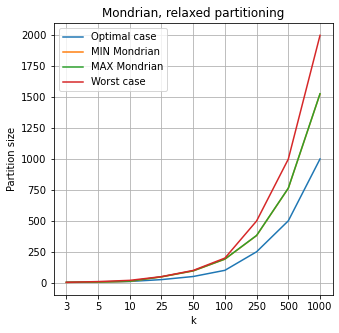

In [21]:
# check whether partition sizes are in the expected range
max_allowed_sizeR = [(2*k)-1 for k in ks]

ks = [3,5,10,25,50,100,250,500,1000]
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), ks, label='Optimal case')
plt.plot(np.arange(len(ks)), min_size_kR, label='MIN Mondrian')
plt.plot(np.arange(len(ks)), max_size_kR, label='MAX Mondrian')
plt.plot(np.arange(len(ks)), max_allowed_sizeR, label='Worst case')
plt.xticks(np.arange(len(ks)), labels=ks)
plt.xlabel('k')
plt.ylabel('Partition size')
plt.title('Mondrian, relaxed partitioning')
plt.legend()
plt.grid()
plt.show()

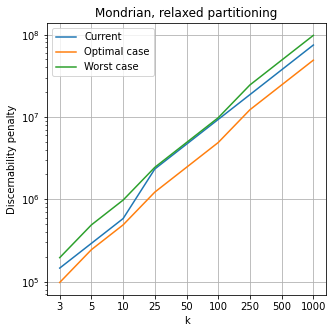

In [22]:
# plot discernability penalty evolution based on k values

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesR, label='Current')
plt.plot(np.arange(len(ks)), optimal_discR, label='Optimal case')
plt.plot(np.arange(len(ks)), worst_discR, label='Worst case')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7,1e8])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Mondrian, relaxed partitioning')
plt.legend()
plt.grid()
plt.show()

In [23]:
# strict mode

ks = [2,5,10,25,50,100,250,500,1000]
discernabilitiesS = []
execution_timesS = []
avg_metricsS = []
mean_size_kS = []
min_size_kS = []
max_size_kS = []
#quasi_identifiers = ['age','workclass','education','marital-status','occupation',
#         'race','sex','native-country']
quasi_identifiers_cols = ['age','workclass','education','marital-status','occupation','race','gender','native-country']
quasi_identifiers = {k: v for k, v in col_dict.items() if v in quasi_identifiers_cols}
sensitive_data_cols = ['income']
sensitive_data = {k: v for k, v in col_dict.items() if v in sensitive_data_cols}

for k in tqdm(ks):
  start = time.time()
  sizes = []
  equivalence_classes = partitioning(df, quasi_identifiers, k, cat_dict, 'strict')
  execution_timesS.append(time.time()-start)

  for i in range(len(equivalence_classes)):
    if len(equivalence_classes[i]) < k: # check partition sizes
      print('issue with k = {}, partition bounds were not respected'.format(k,i,len(equivalence_classes[i])))
    sizes.append(len(equivalence_classes[i]))
  mean_size_kS.append(np.sum(sizes)*1.0/len(equivalence_classes))
  max_size_kS.append(np.max(sizes))
  min_size_kS.append(np.min(sizes))
  
  discernabilitiesS.append(discernability(equivalence_classes))
  avg_metricsS.append(avg_eqclass(len(df),len(equivalence_classes),k))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.56s/it]


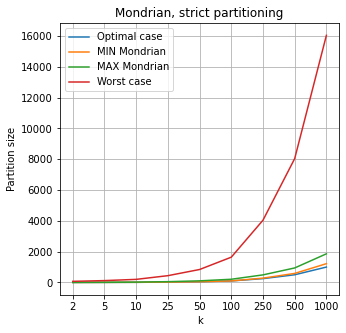

In [24]:
# check whether partition sizes are in the expected range
max_allowed_sizeS = [(2*len(quasi_identifiers)*(k-1))+m for k in ks]

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), ks, label='Optimal case')
plt.plot(np.arange(len(ks)), min_size_kS, label='MIN Mondrian')
plt.plot(np.arange(len(ks)), max_size_kS, label='MAX Mondrian')
plt.plot(np.arange(len(ks)), max_allowed_sizeS, label='Worst case')
plt.xticks(np.arange(len(ks)), labels=ks)
plt.xlabel('k')
plt.ylabel('Partition size')
plt.title('Mondrian, strict partitioning')
plt.legend()
plt.grid()
plt.show()

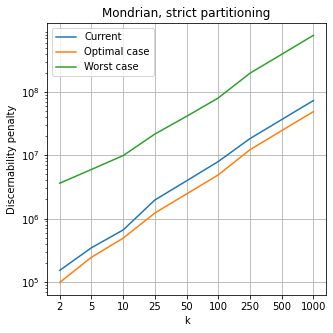

In [25]:
# check if discernability is between optimal and worse
optimal_discS = [k*len(df) for k in ks] # optimal
worst_discS = [] # worse
for k in ks:
  worst_discS.append((2*len(quasi_identifiers)*(k-1)+m)*len(df))

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesS, label='Current')
plt.plot(np.arange(len(ks)), optimal_discS, label='Optimal case')
plt.plot(np.arange(len(ks)), worst_discS, label='Worst case')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7,1e8])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Mondrian, strict partitioning')
plt.legend()
plt.grid()
plt.show()

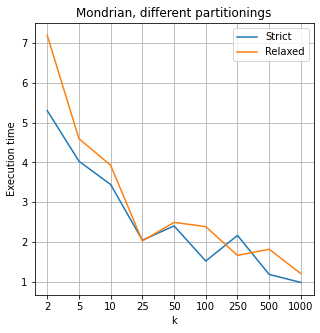

In [26]:
# plot execution time evolution based on k values

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), execution_timesS, label='Strict')
plt.plot(np.arange(len(ks)), execution_timesR, label='Relaxed')
plt.xticks(np.arange(len(ks)), labels=ks)
plt.xlabel('k')
plt.ylabel('Execution time')
plt.title('Mondrian, different partitionings')
plt.legend()
plt.grid()
plt.show()

### Test with synthetic data

In [27]:
from sklearn.preprocessing import KBinsDiscretizer

# generate 10 000 tuples with 5 attributes and per-attribute cardinality = 8
enc = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='kmeans') # discretizer for normal distribution
n_tuples = 10000

# discrete uniform distribution
uniform = np.random.randint(low=0, high=8, size=(n_tuples,5))

# normal distribution (mean = 3.5, std = 0.2, k between 2 and 1000)
n1 = np.random.normal(loc=3.5, scale=0.2, size=(n_tuples,5))
normal1 = enc.fit(n1).transform(n1)

# normal distribution (mean = 3.5, std between 0.1 and 0.5, k = 10)
normal_std = []
stds = [0.1, 0.5, 1, 2, 5]
for std in stds:
  n2 = np.random.normal(loc=3.5, scale=std, size=(n_tuples,5))
  normal = enc.fit(n2).transform(n2)
  normal_std.append(normal)

# normal distribution (k = 10, std = 0.2, d between 2 and 8)
normal_d = []
dimensions = [2, 3, 4, 5, 6, 7, 8]
for d in dimensions:
  n3 = np.random.normal(loc=3.5, scale=0.2, size=(n_tuples,d))
  normal = enc.fit(n3).transform(n3)
  normal_d.append(normal)

100%|██████████| 9/9 [00:03<00:00,  2.29it/s]


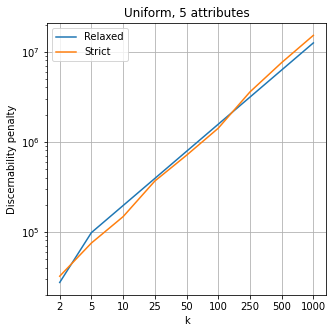

[27344.0, 97840.0, 195440.0, 390640.0, 781264.0, 1562512.0, 3125008.0, 6250000.0, 12500000.0] 
 [32084.0, 74948.0, 147106.0, 365510.0, 706494.0, 1410664.0, 3567828.0, 7554660.0, 15163192.0]


In [294]:
# uniform
ks = [2,5,10,25,50,100,250,500,1000]
discernabilitiesUR = []
discernabilitiesUS = []
cat = {} # no categorical variables

for k in tqdm(ks):
  equivalence_classesR = partitioning(uniform, np.arange(uniform.shape[1]), k, cat, 'relaxed')
  discernabilitiesUR.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(uniform, np.arange(uniform.shape[1]), k, cat, 'strict')
  discernabilitiesUS.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesUR, label='Relaxed')
plt.plot(np.arange(len(ks)), discernabilitiesUS, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Uniform, 5 attributes')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesUR,'\n',discernabilitiesUS)

100%|██████████| 9/9 [00:04<00:00,  2.05it/s]


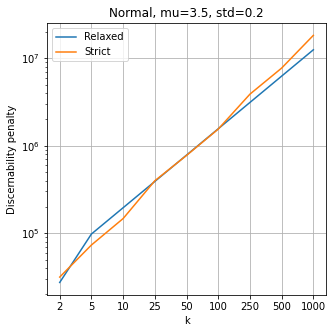

[27344.0, 97840.0, 195440.0, 390640.0, 781264.0, 1562512.0, 3125008.0, 6250000.0, 12500000.0] 
 [31496.0, 73248.0, 147022.0, 397472.0, 774678.0, 1550270.0, 3887620.0, 7724474.0, 18280302.0]


In [295]:
# normal distribution (mean = 3.5, std = 0.2, k between 2 and 1000)
ks = [2,5,10,25,50,100,250,500,1000]
discernabilitiesNR1 = []
discernabilitiesNS1 = []
cat = {} # no categorical variables

for k in tqdm(ks):
  equivalence_classesR = partitioning(normal1, np.arange(normal1.shape[1]), k, cat, 'relaxed')
  discernabilitiesNR1.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(normal1, np.arange(normal1.shape[1]), k, cat, 'strict')
  discernabilitiesNS1.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesNR1, label='Relaxed')
plt.plot(np.arange(len(ks)), discernabilitiesNS1, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Normal, mu=3.5, std=0.2')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesNR1,'\n',discernabilitiesNS1)

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


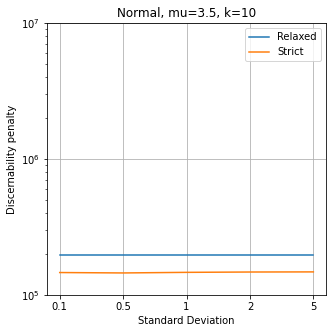

[195440.0, 195440.0, 195440.0, 195440.0, 195440.0] 
 [145824.0, 144802.0, 146278.0, 147116.0, 147414.0]


In [296]:
# normal distribution (mean = 3.5, std between 0.1 and 0.5, k = 10)
k = 10
discernabilitiesNR2 = []
discernabilitiesNS2 = []
cat = {} # no categorical variables

for n in tqdm(normal_std):
  equivalence_classesR = partitioning(n, np.arange(n.shape[1]), k, cat, 'relaxed')
  discernabilitiesNR2.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(n, np.arange(n.shape[1]), k, cat, 'strict')
  discernabilitiesNS2.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(stds)), discernabilitiesNR2, label='Relaxed')
plt.plot(np.arange(len(stds)), discernabilitiesNS2, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(stds)), labels=stds)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('Standard Deviation')
plt.ylabel('Discernability penalty')
plt.title('Normal, mu=3.5, k=10')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesNR2,'\n',discernabilitiesNS2)

100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


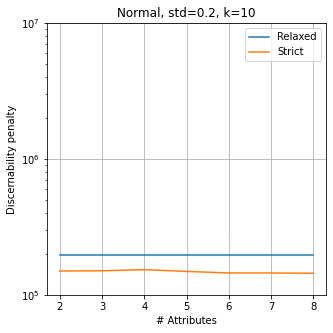

[195440.0, 195440.0, 195440.0, 195440.0, 195440.0, 195440.0, 195440.0] 
 [149626.0, 150170.0, 153102.0, 148624.0, 144726.0, 144706.0, 144086.0]


In [297]:
# normal distribution (k = 10, std = 0.2, d between 2 and 8)
k = 10
discernabilitiesNR3 = []
discernabilitiesNS3 = []
cat = {} # no categorical variables

for n in tqdm(normal_d):
  equivalence_classesR = partitioning(n, np.arange(n.shape[1]), k, cat, 'relaxed')
  discernabilitiesNR3.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(n, np.arange(n.shape[1]), k, cat, 'strict')
  discernabilitiesNS3.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(dimensions)), discernabilitiesNR3, label='Relaxed')
plt.plot(np.arange(len(dimensions)), discernabilitiesNS3, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(dimensions)), labels=dimensions)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('# Attributes')
plt.ylabel('Discernability penalty')
plt.title('Normal, std=0.2, k=10')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesNR3,'\n',discernabilitiesNS3)